# Chapter 6
## Detection Using YOLO

In [3]:
import os, sys
import numpy as np
from math import floor
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from tqdm import tqdm
import h5py
from scipy import signal
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
from sample import Sample
from dataset import Dataset
from database import Database
from cfar_detector import CFARDetector
from detector_generator import DetectorGenerator
from yolo_data_aug import YOLODataAug

dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
result_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','results', 'awdEvents1')
site = 'marion'
database = Database(dataset_loc, database_loc, site)
# dataset_sim = DatasetSimulation(dataset_sim_loc, 0.006395061728395062, 0.15503875968992248)
yolo_aug = YOLODataAug(dataset_loc, database_loc, site)

linewidth = 2
font_title = 32
font_legend = 20
font_label = 24
font_ticks = 18
font = [font_title, font_legend, font_label, font_ticks, linewidth] # [None]*5

##  **6.2 YOLO dataset generation**

### YOLO dataset from Data

In [6]:
transforms, transforms_params = [[None], ['zscore'], ['detrend'], ['detrend']],[[None], [None], ['constant'], ['linear']]
for t, t_params in zip(transforms, transforms_params):
    database.generate_yolo(t, t_params)
    database.yolo_data_split()

100%|██████████| 2196/2196 [02:15<00:00, 16.17it/s]


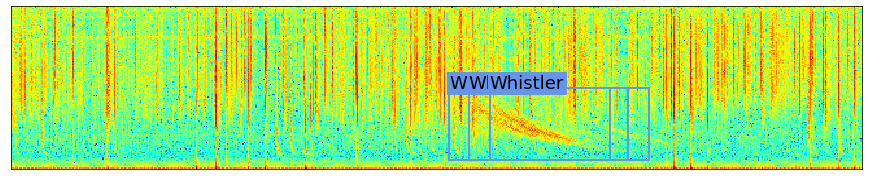

In [5]:
t, t_params = [None], [None]
file = database.get_random_sample()
data, labels = database.load_yolo_file(file,t, t_params)
database.show_yolo_labelled_img(data,labels, rgb=False, noise=False, cmap='jet', font=font)

### Dataset augmentation

In [4]:
aug_t = ['flip', 'scale']

**Flip**

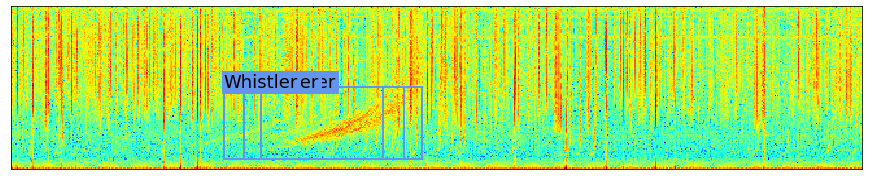

In [15]:
img, bboxes = yolo_aug.data_aug(file, ['flip'], t, t_params)
bboxes = yolo_aug.bbox_index_to_norm(img, bboxes)
database.show_yolo_labelled_img(img,bboxes, rgb=False, noise=False, cmap='jet', font=font)

**Scale**

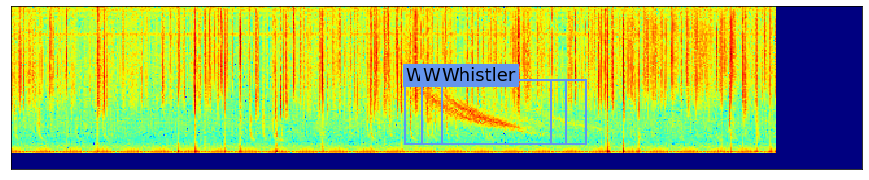

In [19]:
img, bboxes = yolo_aug.data_aug(file, ['scale'], t, t_params)
bboxes = yolo_aug.bbox_index_to_norm(img, bboxes)
database.show_yolo_labelled_img(img,bboxes, rgb=False, noise=False, cmap='jet', font=font)